In [91]:
import numpy as np

In [30]:
def load_labels(path):
    with open(path, "r") as f:
        all_preds = f.readlines()
    preds_processed = [[int(e) for e in pred.strip('\n').split()] for pred in all_preds]
    return np.array(preds_processed)

Load label names

In [103]:
with open("test_labels.txt", "r") as f:
    label_names = f.readlines()[0].split(" ")

In [104]:
label_names

['Drama',
 'Film-Noir',
 'Mystery',
 'Thriller',
 'Adventure',
 'Crime',
 'Horror',
 'Romance',
 'Sport',
 'Fantasy',
 'Biography',
 'Action',
 'Music',
 'War',
 'Documentary',
 'Short',
 'Animation',
 'Comedy',
 'Family',
 'Musical',
 'Sci-Fi',
 'Western',
 'History']

In [226]:
label2idx = dict([(name, i) for i, name in enumerate(label_names)])

Load test gold predictions

In [31]:
gold_preds = load_labels("model_save_vilbert/vilbert_model_run/test_labels_gold.txt")
print(f"Preds shape: {gold_preds.shape}")

Preds shape: (7799, 23)


Count total predictions by label

In [81]:
import collections

preds_unfold = []
for pred in gold_preds:
    preds_unfold.extend(list(np.where(pred == 1)[0]))
    
counts = collections.Counter(preds_unfold)
sorted(counts.items())

[(0, 4142),
 (1, 102),
 (2, 617),
 (3, 1567),
 (4, 821),
 (5, 1163),
 (6, 825),
 (7, 1590),
 (8, 191),
 (9, 585),
 (10, 411),
 (11, 1044),
 (12, 311),
 (13, 401),
 (14, 629),
 (15, 142),
 (16, 306),
 (17, 2611),
 (18, 518),
 (19, 253),
 (20, 586),
 (21, 210),
 (22, 345)]

Get indexes of examples wehre prediction should be made by label

indexesByLabel[0] -> Indexes of gold_preds where prediction should be made for class 0 <br>
indexesByLabel[1] -> Indexes of gold_preds where prediction should be made for class 1 <br>
...

In [82]:
indexesByLabel = []
for i in range(23):
    exampleIndexes = []
    for idx, pred in enumerate(gold_preds):
        if pred[i] == 1:
            exampleIndexes.append(idx)
    indexesByLabel.append(exampleIndexes)

Load test predictions

In [127]:
vilbert_preds = load_labels("model_save_vilbert/vilbert_model_run/test_labels_pred.txt")
print(f"ViLBERT preds shape: {vilbert_preds.shape}")

mmbt3_preds = load_labels("model_save_mmbt3/mmbt3_model_run/test_labels_pred.txt")
print(f"mmbt3 preds shape: {mmbt3_preds.shape}")

ViLBERT preds shape: (7799, 23)
mmbt3 preds shape: (7799, 23)


Process counts of correct predictions for each label (0, 1, 2, ..., 22)

In [116]:
import pandas as pd

def freqs_dataframe(data_preds, model_name, label_names):
    countsLabel = []

    for class_id, idxsList in enumerate(indexesByLabel):
        count = 0
        for idx in idxsList:
            if data_preds[idx][class_id] == 1:
                count += 1
        countsLabel.append(count/len(idxsList))
        
    df = pd.DataFrame()
    df['label'] = label_names
    df['freq'] = countsLabel
    df['model'] = [model_name]*len(label_names)
            
    return df

In [184]:
vilbert_freqs = freqs_dataframe(vilbert_preds, "vilbert", label_names)
mmbt3_freqs = freqs_dataframe(mmbt3_preds, "mmbt3", label_names)
all_models_freqs = pd.concat([vilbert_freqs, mmbt3_freqs])

Plot and compare accuracy per label (movie genre) of all models

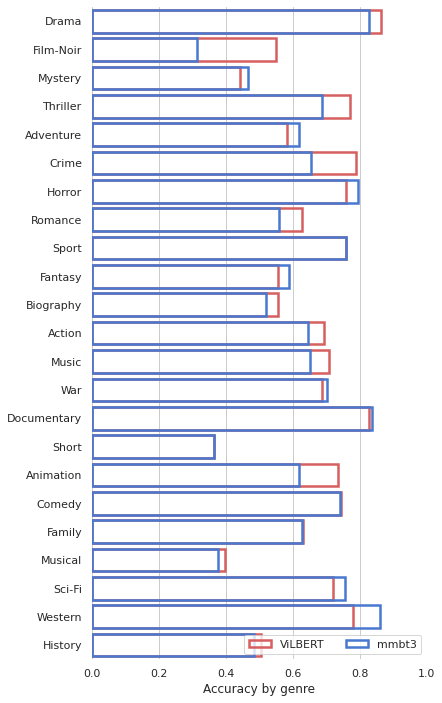

In [176]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")

f, ax = plt.subplots(figsize=(6, 12))


sns.set_color_codes("muted")

sns.barplot(x="freq", y="label", data=vilbert_freqs,
            label="ViLBERT", edgecolor="r", facecolor=(1, 1, 1, 0), linewidth=2.5)

ax_bar = sns.barplot(x="freq", y="label", data=mmbt3_freqs,
            label="mmbt3", edgecolor="b", facecolor=(1, 1, 1, 0), linewidth=2.5)

ax.legend(ncol=2, loc="lower right", frameon=True)
ax.set(xlim=(0, 1), ylabel="",
       xlabel="Accuracy by genre")
sns.despine(left=True, bottom=True)

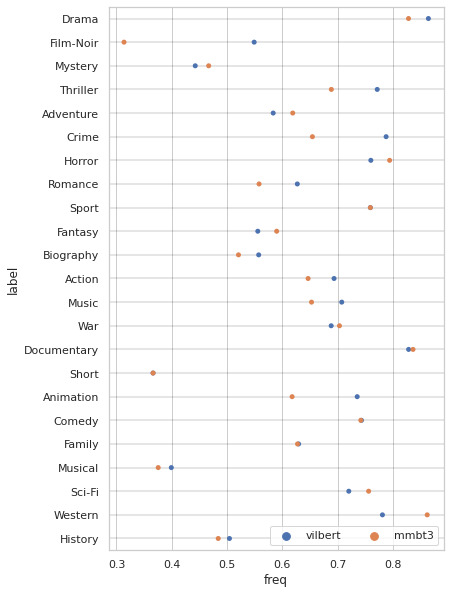

In [199]:
f, ax = plt.subplots(figsize=(6, 10))
ax_points = sns.stripplot(x="freq", y="label", data=all_models_freqs, hue="model", jitter=0)
ax.legend(ncol=2, loc="lower right", frameon=True)

for i in range(len(label_names)):
    ax_points.axhline(i, color='black', alpha=0.1, lw = 2)

Plot correct predictions of each example by label (movie genre)

In [219]:
def pred_class_dataframe(data_preds_list, label_id):
    binary_preds = []
    ids = []
    model_name = []
    origin_ids = []

    for name, data_preds in data_preds_list.items():
        for i, idx in enumerate(indexesByLabel[label_id]):
            binary_preds.append(1 if data_preds[idx][label_id] == gold_preds[idx][label_id] else 0)
            ids.append(i)
            model_name.append(name)
            origin_ids.append(idx)
    
    df = pd.DataFrame()
    df['result'] = binary_preds
    df['id'] = ids
    df['model'] = model_name
    df['origin_id'] = origin_ids
            
    return df

In [239]:
preds_all_models = {'vilbert': vilbert_preds,
                    'mmbt3': mmbt3_preds}

results_model = pred_class_dataframe(preds_all_models, label2idx['Short'])

In [ ]:
f, ax = plt.subplots(figsize=(6, 10))
sns.stripplot(x="id", y="result", data=results_model, hue="model", jitter=0)
ax.legend(ncol=2, loc="lower right", frameon=True)

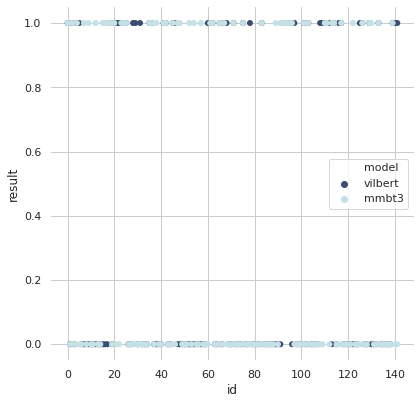

In [244]:
f, ax = plt.subplots(figsize=(6.5, 6.5))
sns.despine(f, left=True, bottom=True)
#clarity_ranking = ["I1", "SI2", "SI1", "VS2", "VS1", "VVS2", "VVS1", "IF"]
sns.scatterplot(x="id", y="result",
                hue="model",
                palette="ch:r=-.2,d=.3_r",
                sizes=(1, 1), linewidth=0,
                data=results_model, ax=ax)

Get test dataset idexes for a specific label where all models' predictions are incorrect

In [223]:
def pred_class_dataframe_ids(data_preds, label_id):
    binary_preds = []
    origin_ids = []

    for i, idx in enumerate(indexesByLabel[label_id]):
        binary_preds.append(1 if data_preds[idx][label_id] == gold_preds[idx][label_id] else 0)
        origin_ids.append(idx)
    
    df = pd.DataFrame()
    df['result'] = binary_preds
    df['origin_id'] = origin_ids
            
    return df

In [233]:
vilbert_results_model_ids = pred_class_dataframe_ids(vilbert_preds, label2idx['Short'])
mmbt3_results_model_ids = pred_class_dataframe_ids(mmbt3_preds, label2idx['Short'])

In [236]:
incorrect_pred = vilbert_results_model_ids['result'] == 0
vilbert_incorrect = vilbert_results_model_ids[incorrect_pred]

incorrect_pred = mmbt3_results_model_ids['result'] == 0
mmbt3_incorrect = mmbt3_results_model_ids[incorrect_pred]

In [238]:
pd.merge(vilbert_incorrect, mmbt3_incorrect, how='inner', on=['origin_id'])['origin_id']

0     103
1     105
2     108
3     110
4     112
     ... 
67    236
68    237
69    238
70    239
71    240
Name: origin_id, Length: 72, dtype: int64